## <b>EDA Process </b>

Load the dataset and explore

In [11]:
import os
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
import torch
from scipy import signal
import numpy as np
import heartpy.filtering

In [2]:

database_path = "mit-bih-normal-sinus-rhythm-database-1.0.0/" # Path to the MIT-BIH Normal Sinus Rhythm Database
data_files = [database_path + file for file in os.listdir(database_path) if ".dat" in file]
save_path = '/save_path/' # Path to save the processed dataset


In [3]:
data_files

['mit-bih-normal-sinus-rhythm-database-1.0.0/16265.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/16272.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/16273.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/16420.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/16483.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/16539.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/16773.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/16786.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/16795.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/17052.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/17453.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/18177.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/18184.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/19088.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/19090.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/19093.dat',
 'mit-bih-normal-sinus-rhythm-database-1.0.0/19140.dat',
 'mit-bih-normal-sinus-rhythm-d

In [4]:
names_samples = []
fs = 128
win = 5
fs_new = 128
signal_quality = []

counters = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0,
            16: 0, 17: 0}

In [5]:
## Loop ecg.bin files
part = 0
for participant, file in enumerate(data_files):
    counter = 0

    if participant == part:
        #Get signal
        data = pd.DataFrame({"ECG":wfdb.rdsamp(file[:-4])[0][:,0]})
        data["Participant"] = "MIT-Normal_%.2i" %(participant)
        data["Sample"] = range(len(data))
        data["Sampling_Rate"] = 128
        data["Database"] = "MIT-Normal"

data.head()
    

,ECG,Participant,Sample,Sampling_Rate,Database
0,-0.165,MIT-Normal_00,0,128,MIT-Normal
1,-0.155,MIT-Normal_00,1,128,MIT-Normal
2,-0.195,MIT-Normal_00,2,128,MIT-Normal
3,-0.205,MIT-Normal_00,3,128,MIT-Normal
4,-0.185,MIT-Normal_00,4,128,MIT-Normal


In [6]:
data = data["ECG"].values

In [7]:
ECG_SIGNAL = torch.Tensor(data)
window_complete = ECG_SIGNAL[0:win*fs]

### <b>Data Preprocessing. </b>

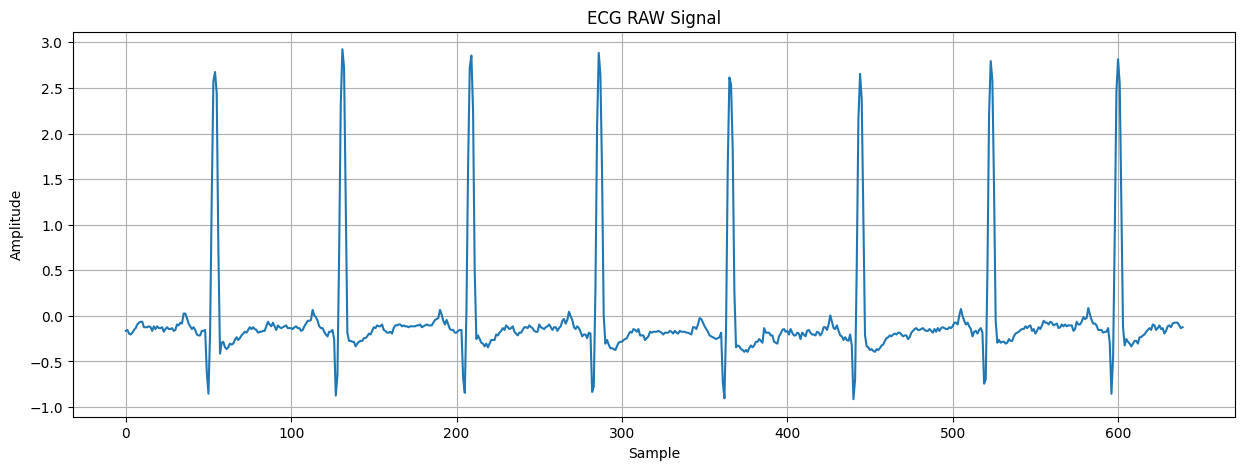

In [8]:
#Plot the signal
plt.figure(figsize=(15, 5))
plt.plot(window_complete)
plt.title("ECG RAW Signal")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

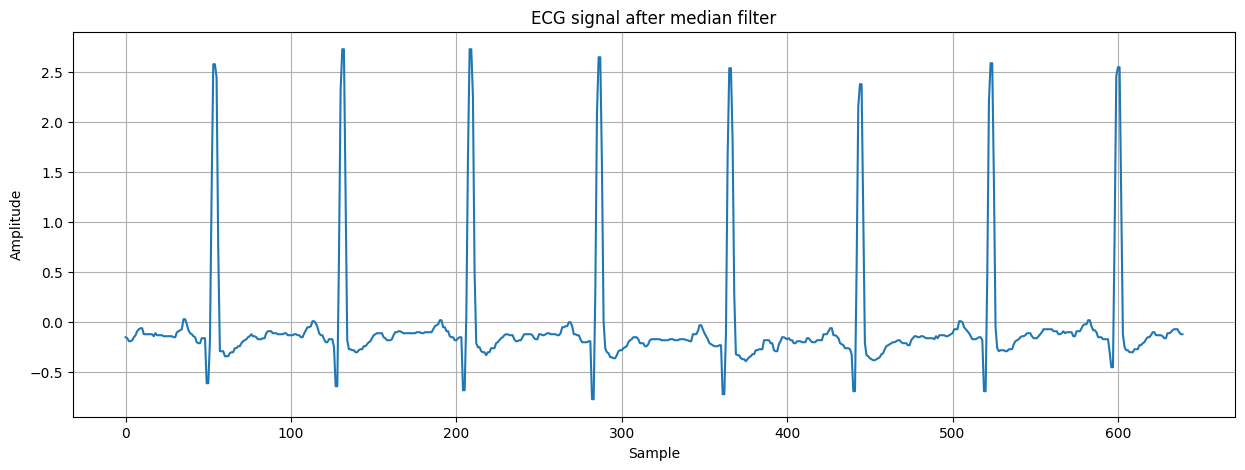

In [9]:
med = signal.medfilt(window_complete, 3)

plt.figure(figsize=(15, 5))
plt.plot(med)
plt.title("ECG signal after median filter")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

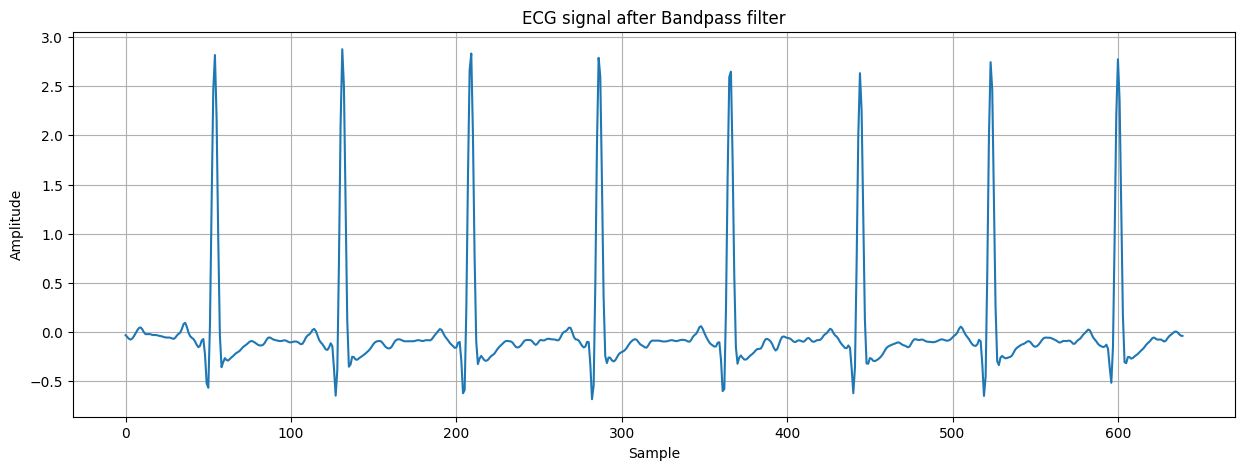

In [12]:
filt = heartpy.filtering.filter_signal(med, [0.5, 30], fs, order=2,
                                                           filtertype='bandpass')

plt.figure(figsize=(15, 5))
plt.plot(filt)
plt.title("ECG signal after Bandpass filter")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

### <b>Data Validating. </b>

In [ ]:
signal_quality_now = []
win_intra = 1

for k in range(win_intra * fs, window_complete.shape[0] + 1, win_intra * fs):
    min_limit = k - win_intra * fs
    max_limit = k
    window_complete_intra = filt[min_limit:max_limit]

128


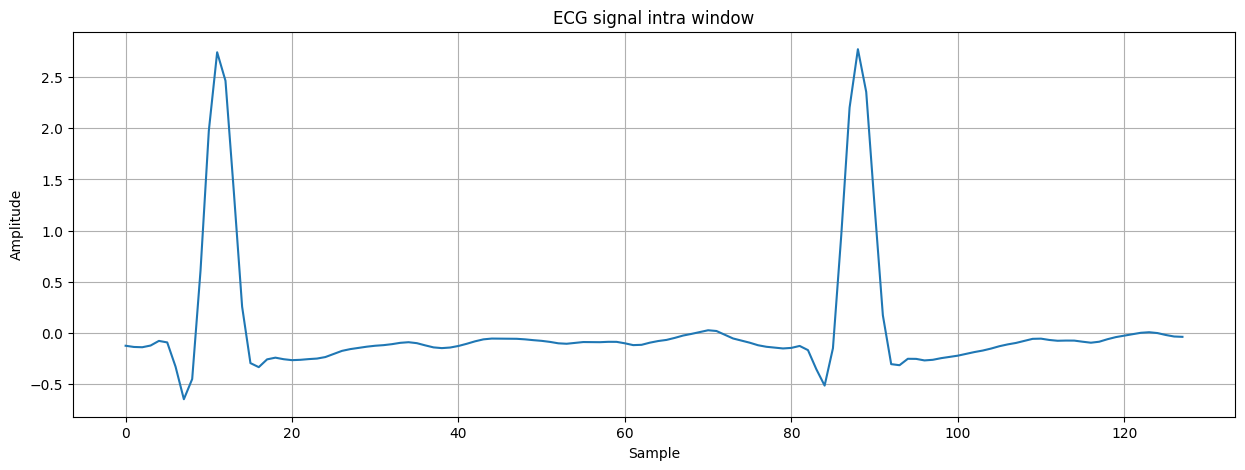

In [22]:
# plot the intra window
plt.figure(figsize=(15, 5))
plt.plot(window_complete_intra)
plt.title("ECG signal intra window")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid()
plt.show()


This class determines the quality of an ECG segment, usually lasting several seconds. It computes SQIs (Signal Quality Indicator) and use them in a pre-trained model to predict the quality:

        1 : good quality
        0 : bad quality


From an ECG segment signal, use pre-trained model to compute the quality of the signal. This method is a shortcut to using compute_sqi_scores then predict quality.

#### <b>compute sqi scores. </b>
From an ECG Signal segment, computes 6 SQI scores (q_sqi, c_sqi, s_sqi,k_sqi, p_sqi, bas_sqi)


In [23]:
from sklearn.preprocessing import StandardScaler

In [25]:
# Normalizing the signal
ecg_signal = StandardScaler().fit_transform(window_complete_intra.reshape(-1, 1)).reshape(1, -1)[0]

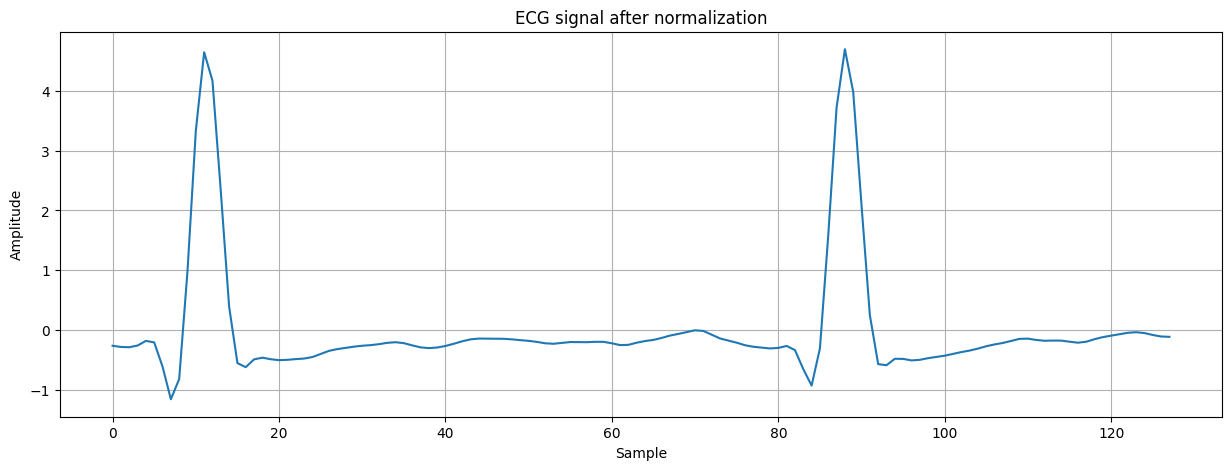

In [26]:
# plot the ecg signal after normalization
plt.figure(figsize=(15, 5))
plt.plot(ecg_signal)
plt.title("ECG signal after normalization")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

### 1.Variability in the R-R Interval

aims to quantify how much variability there is in the intervals between successive R-peaks (R-R intervals) detected in the ECG.High variability often indicates poor signal quality due to artifacts. 

In [27]:
import biosppy.signals.ecg as bsp_ecg

QRS detection method (bsp_ecg.hamilton_segmenter) to identify the R-peaks in the ECG signal. This method returns a list of detected R-R intervals (time intervals between consecutive R-peaks).

In [28]:
rri_list = bsp_ecg.hamilton_segmenter(
    signal=np.array(ecg_signal),
    sampling_rate=fs
)
print("R-R intervals:", rri_list)

R-R intervals: ReturnTuple(rpeaks=array([11, 88]))


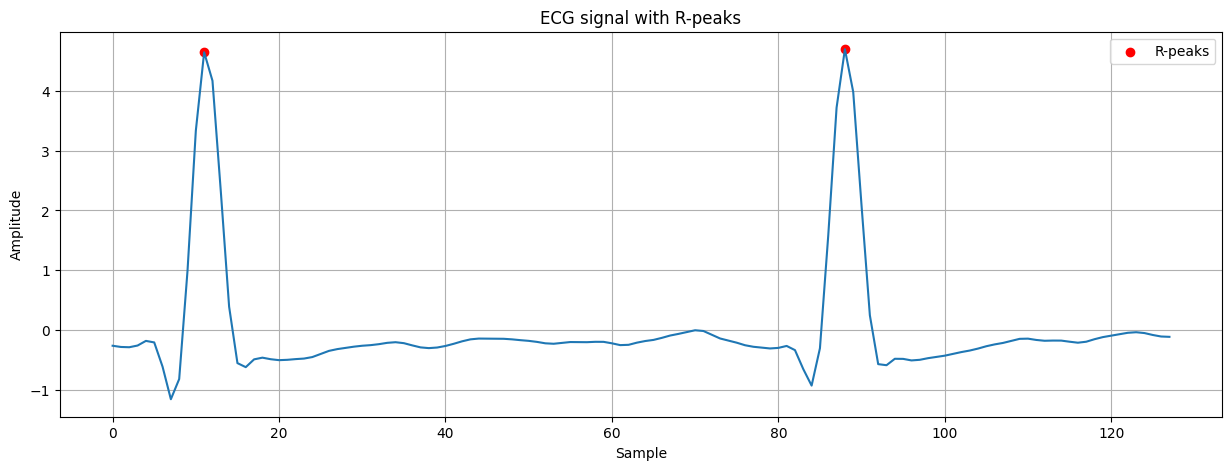

In [33]:
# plot the ecg signal and mark the R-peaks
plt.figure(figsize=(15, 5))
plt.plot(ecg_signal)
plt.scatter(rri_list, ecg_signal[rri_list], color='red', label='R-peaks')
plt.title("ECG signal with R-peaks")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

Calculates the coefficient of variation of these R-R intervals, computed as the standard deviation (with Bessel's correction, ddof=1) divided by the mean of the R-R intervals.

In [34]:
c_sqi_score = float(np.round(
    np.std(rri_list,ddof=1)/np.mean(rri_list),3
))
print("c_sqi_score:", c_sqi_score)

c_sqi_score: 1.1


#### Matching Degree of R Peak Detection

Two R wave detection algorithms are compared with their respective number of R waves detected.

    * Hamilton
    * SWT (Stationary Wavelet Transform)


In [35]:
from ecgdetectors import Detectors

To evaluate ECG signal quality by comparing the R-peak detections made by two separate algorithms:

    Hamilton detector: A classic R-peak detection method.
    SWT detector: Uses the Stationary Wavelet Transform for R-peak detection.

Their agreement on detected R-peaks serves as a signal quality index.

In [36]:
detectors = Detectors(fs)
qrs_frames_swt = detectors.swt_detector(ecg_signal)
qrs_frames_hamilton = bsp_ecg.hamilton_segmenter(
    signal = np.array(ecg_signal),
    sampling_rate = fs)

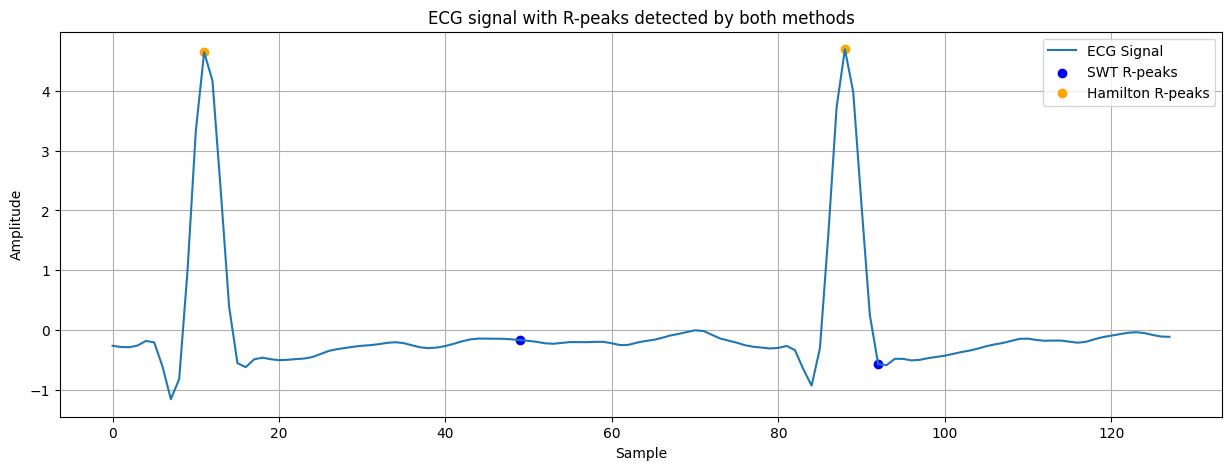

In [ ]:
# plot the signal with R-peaks detected by both methods
plt.figure(figsize=(15, 5))
plt.plot(ecg_signal, label='ECG Signal')
plt.scatter(qrs_frames_swt, ecg_signal[qrs_frames_swt], color='blue', label='SWT R-peaks')
plt.scatter(qrs_frames_hamilton, ecg_signal[qrs_frames_hamilton], color='orange', label='Hamilton R-peaks')
plt.title("ECG signal with R-peaks detected by both methods")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

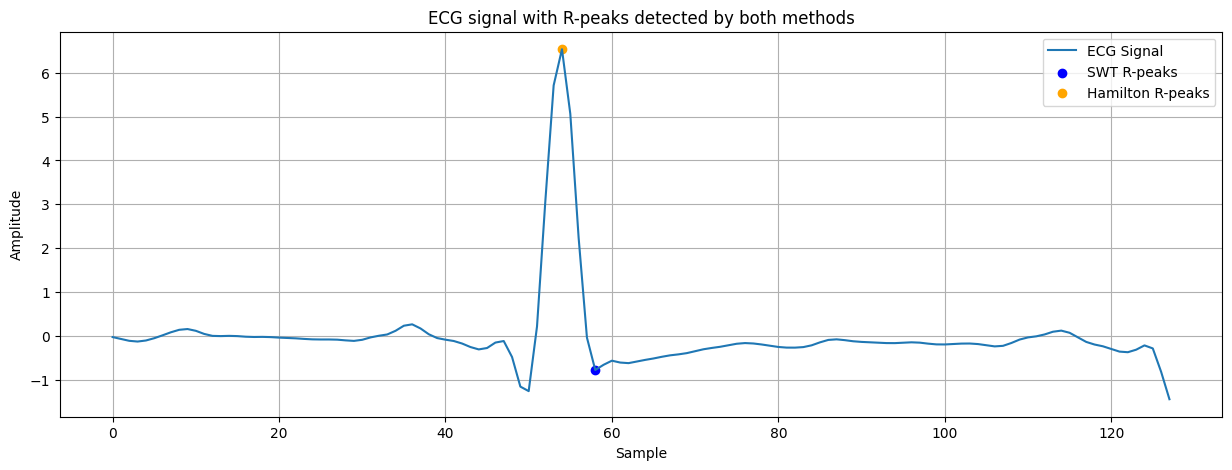

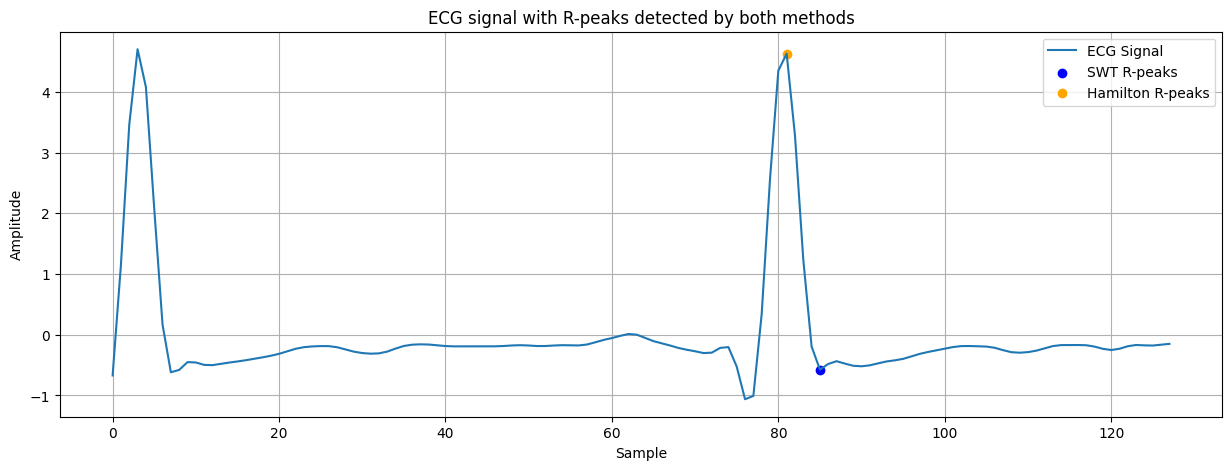

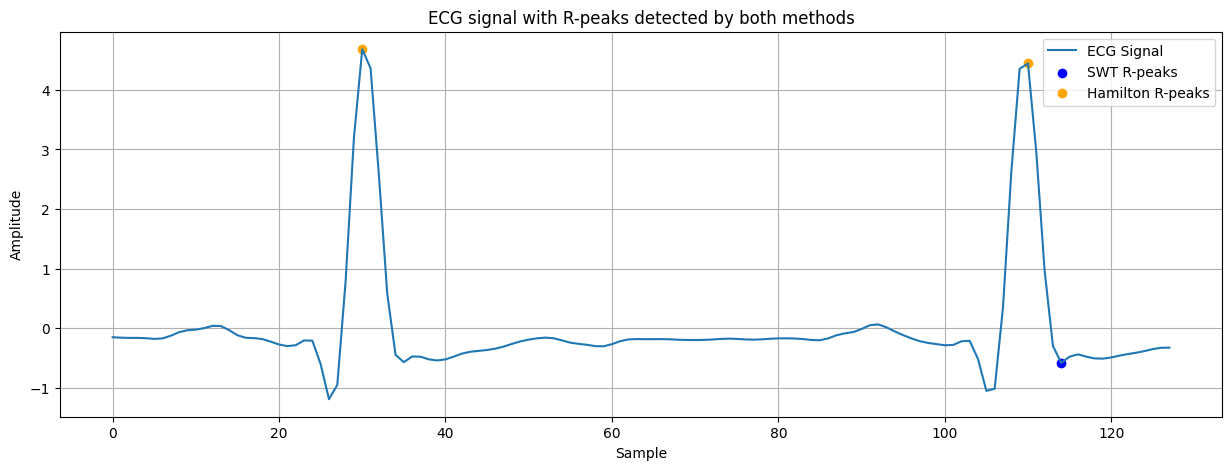

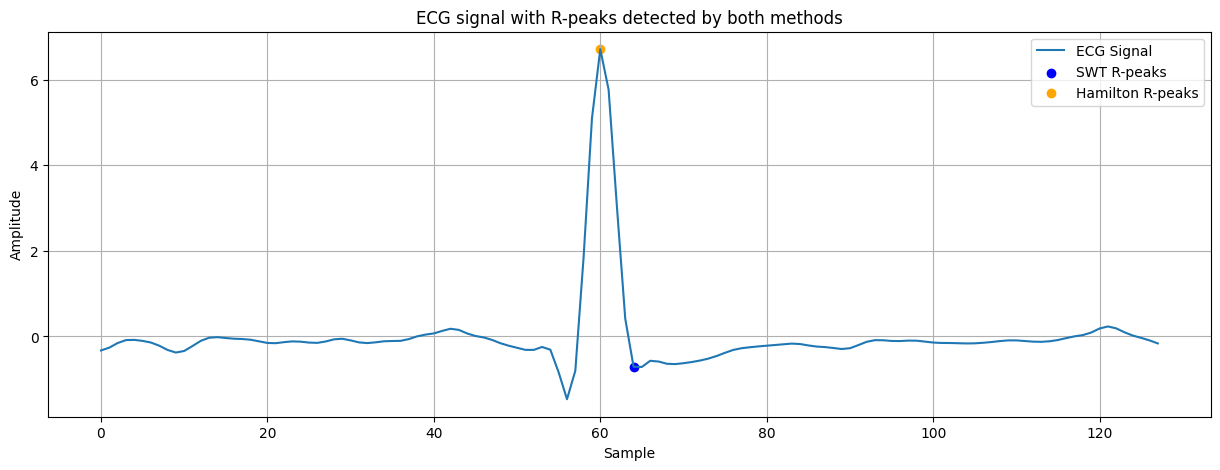

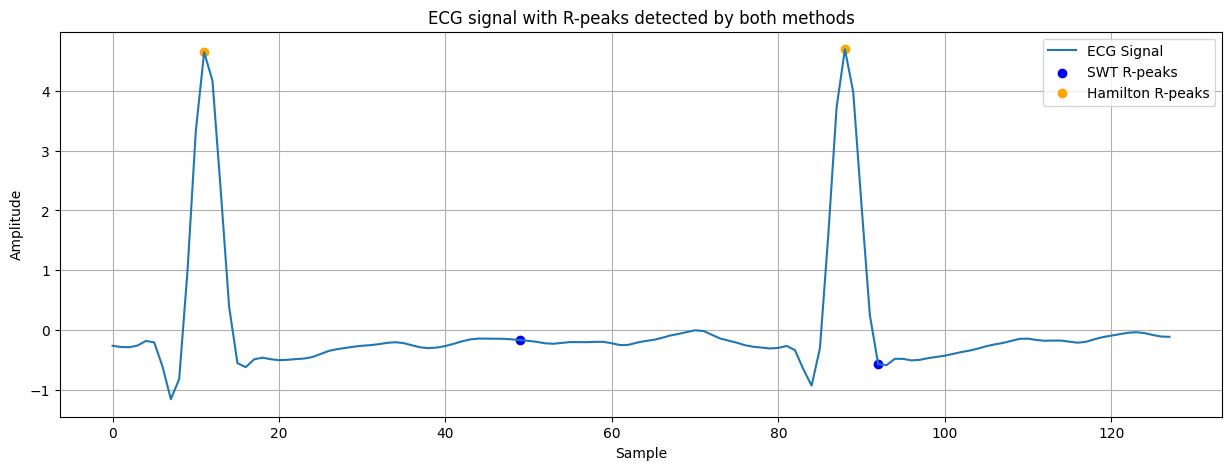

In [43]:
signal_quality_now = []
win_intra = 1

for k in range(win_intra * fs, window_complete.shape[0] + 1, win_intra * fs):
    min_limit = k - win_intra * fs
    max_limit = k
    window_complete_intra = filt[min_limit:max_limit]
    # Normalizing the signal
    ecg_signal = StandardScaler().fit_transform(window_complete_intra.reshape(-1, 1)).reshape(1, -1)[0]

    detectors = Detectors(fs)
    qrs_frames_swt = detectors.swt_detector(ecg_signal)
    qrs_frames_hamilton = bsp_ecg.hamilton_segmenter(
        signal = np.array(ecg_signal),
        sampling_rate = fs)
    
    # plot the signal with R-peaks detected by both methods
    plt.figure(figsize=(15, 5))
    plt.plot(ecg_signal, label='ECG Signal')
    plt.scatter(qrs_frames_swt, ecg_signal[qrs_frames_swt], color='blue', label='SWT R-peaks')
    plt.scatter(qrs_frames_hamilton, ecg_signal[qrs_frames_hamilton], color='orange', label='Hamilton R-peaks')
    plt.title("ECG signal with R-peaks detected by both methods")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid()
    plt.show()
    

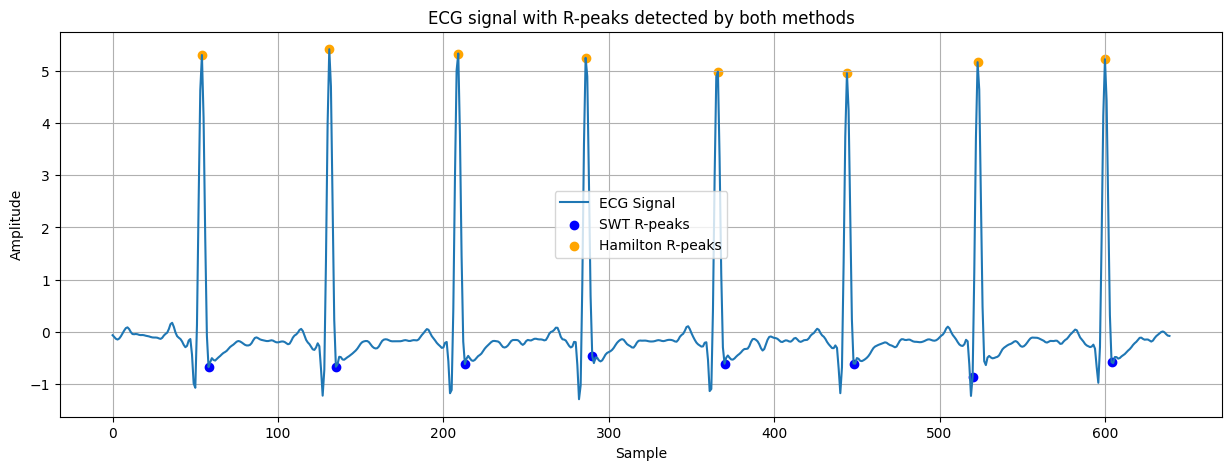

In [44]:
ecg_signal_full = StandardScaler().fit_transform(filt.reshape(-1, 1)).reshape(1, -1)[0]

detectors = Detectors(fs)
qrs_frames_swt = detectors.swt_detector(ecg_signal_full)
qrs_frames_hamilton = bsp_ecg.hamilton_segmenter(
    signal = np.array(ecg_signal_full),
    sampling_rate = fs)

# plot the signal with R-peaks detected by both methods
plt.figure(figsize=(15, 5))
plt.plot(ecg_signal_full, label='ECG Signal')
plt.scatter(qrs_frames_swt, ecg_signal_full[qrs_frames_swt], color='blue', label='SWT R-peaks')
plt.scatter(qrs_frames_hamilton, ecg_signal_full[qrs_frames_hamilton], color='orange', label='Hamilton R-peaks')
plt.title("ECG signal with R-peaks detected by both methods")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

calculates a similarity score (correlation coefficient) between two lists of detected QRS frames (R-peak positions) from ECG signals. This score reflects how well two R-peak detection methods agree on the positions of detected beats.